Überlegung: XGboost zur vorhersage einbauen
das muss aber mit den staffeln passieren, wo ich das ergebnis schon kenne um ein modell zu bauen


[Ceremony 1] Found 1 confirmed perfect match(es).
[Ceremony 1] New Score: 1
[Ceremony 2] Found 1 confirmed perfect match(es).
[Ceremony 2] New Score: 2
[Ceremony 3] Found 1 confirmed perfect match(es).
[Ceremony 3] New Score: 3
[Ceremony 4] Found 2 confirmed perfect match(es).
[Ceremony 4] New Score: 2
[Ceremony 5] Found 2 confirmed perfect match(es).
[Ceremony 5] New Score: 2


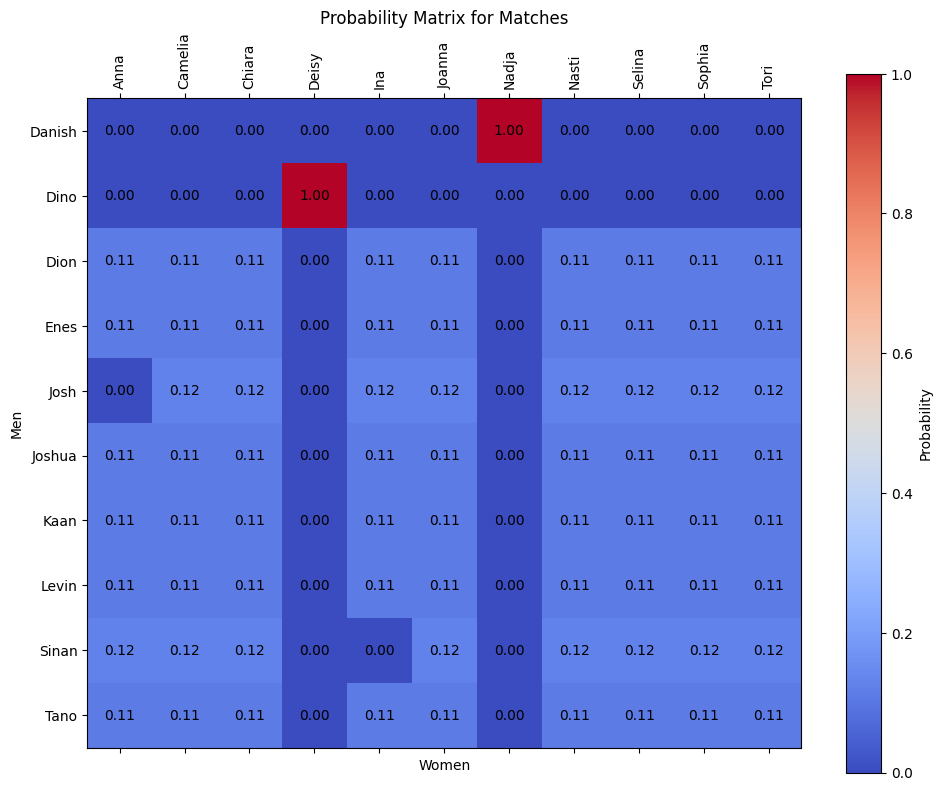


Häufigkeit der Paare (über alle Match Ceremonies):
Dino - Deisy: 5 mal
Levin - Camelia: 4 mal
Joshua - Joanna: 4 mal
Tano - Tori: 4 mal
Josh - Nadja: 3 mal
Kaan - Anna: 3 mal
Enes - Selina: 3 mal
Sinan - Ina: 2 mal
Danish - Sophia: 2 mal
Sinan - Nasti: 2 mal
Dion - Chiara: 2 mal
Josh - Ina: 2 mal
Danish - Nadja: 2 mal
Kaan - Joanna: 1 mal
Dion - Tori: 1 mal
Enes - Anna: 1 mal
Joshua - Selina: 1 mal
Tano - Chiara: 1 mal
Dion - Selina: 1 mal
Enes - Nasti: 1 mal
Danish - Camelia: 1 mal
Levin - Chiara: 1 mal
Sinan - Sophia: 1 mal
Dion - Nasti: 1 mal
Kaan - Sophia: 1 mal


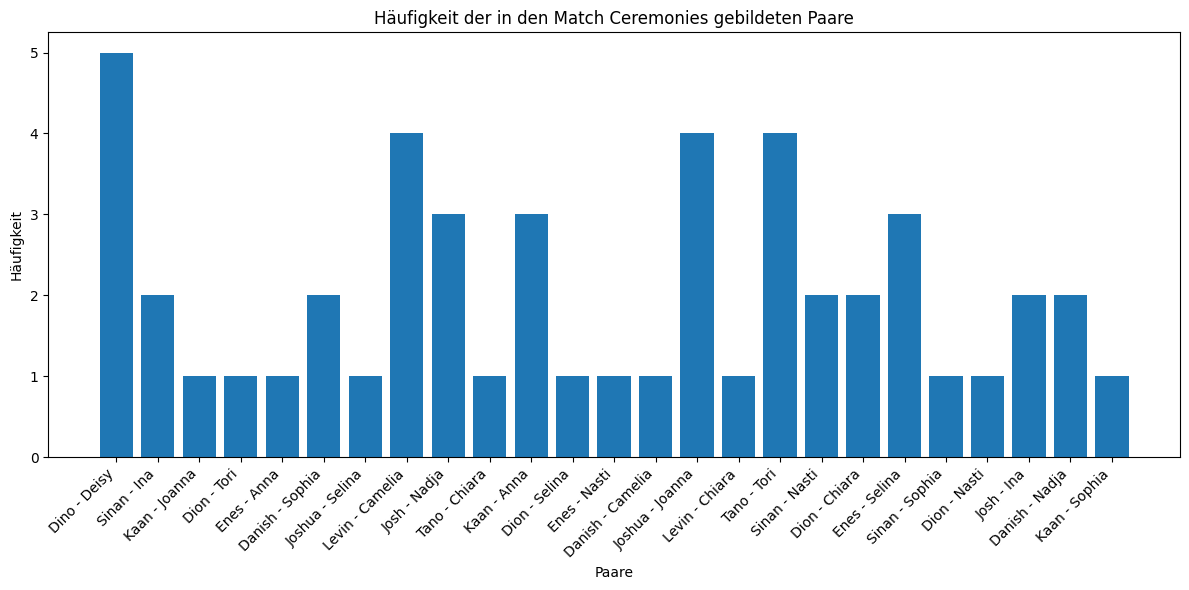

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

def load_data(filename):
    """
    Load JSON data from the given file.
    """
    with open(filename, 'r') as f:
        return json.load(f)


def initialize_probabilities(participants):
    """
    Initialize a probabilities dictionary and a fixed dictionary for all man-woman pairs.
    - probabilities[(man, woman)] starts at 0.5
    - fixed[(man, woman)] starts as False
    """
    probabilities = {}
    fixed = {}
    men = [man.lower() for man in participants['men']]
    women = [woman.lower() for woman in participants['women']]
    for man in men:
        for woman in women:
            probabilities[(man, woman)] = 0.5
            fixed[(man, woman)] = False
    return probabilities, fixed


def update_truth_booths(probabilities, fixed, truth_booths):
    """
    Update probabilities and fixed values based on truth booth results:
    - If a pair is confirmed as a match, set probability to 1.0 and exclude that man or woman from any other pair.
    - If a pair is confirmed not a match, set its probability to 0.0.
    """
    for booth in truth_booths:
        man = booth['man'].lower()
        woman = booth['woman'].lower()
        pair = (man, woman)

        if booth['is_match']:
            # Confirm this pair
            probabilities[pair] = 1.0
            fixed[pair] = True
            # Exclude this man from any other pair
            for other_pair in list(probabilities.keys()):
                if other_pair[0] == man and other_pair != pair:
                    probabilities[other_pair] = 0.0
                    fixed[other_pair] = True
            # Exclude this woman from any other pair
            for other_pair in list(probabilities.keys()):
                if other_pair[1] == woman and other_pair != pair:
                    probabilities[other_pair] = 0.0
                    fixed[other_pair] = True
        else:
            # Confirm they are not a match
            probabilities[pair] = 0.0
            fixed[pair] = True

    return probabilities, fixed


def normalize_possible_pairs(probabilities, fixed, participants):
    """
    Normalize probabilities for each man to ensure that if no pair is fixed to 1.0 for that man,
    the sum of probabilities for the remaining potential partners is 1.0.
    """
    men = [m.lower() for m in participants['men']]
    women = [w.lower() for w in participants['women']]

    for man in men:
        # Check if there's already a fixed perfect match for this man
        has_fixed_match = any(
            fixed[(man, woman)] and probabilities[(man, woman)] == 1.0
            for woman in women
        )
        if has_fixed_match:
            continue

        # If not, spread probability evenly among all remaining possible women
        possible_women = [woman for woman in women if not fixed[(man, woman)]]
        if possible_women:
            new_prob = 1.0 / len(possible_women)
            for woman in possible_women:
                probabilities[(man, woman)] = new_prob

    return probabilities


def plot_probability_matrix(probabilities, participants):
    """
    Plot a probability matrix (men vs. women) as a heatmap.
    """
    men = [m.lower() for m in participants['men']]
    women = [w.lower() for w in participants['women']]

    matrix = np.zeros((len(men), len(women)))

    for i, man in enumerate(men):
        for j, woman in enumerate(women):
            matrix[i, j] = probabilities.get((man, woman), 0)

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(matrix, cmap='coolwarm', vmin=0, vmax=1)

    plt.xticks(ticks=np.arange(len(women)), labels=[w.capitalize() for w in women], rotation=90)
    plt.yticks(ticks=np.arange(len(men)), labels=[m.capitalize() for m in men])

    for i in range(len(men)):
        for j in range(len(women)):
            ax.text(j, i, f"{matrix[i, j]:.2f}", ha='center', va='center', color='black')

    plt.colorbar(cax, label="Probability")
    plt.xlabel("Women")
    plt.ylabel("Men")
    plt.title("Probability Matrix for Matches")
    plt.tight_layout()
    plt.show()


def count_pair_occurrences(data):

    # Zählt, wie oft jedes Paar in den Match Ceremonies ausgewählt wurde.    
    pair_counts = {}
    for ceremony in data.get('match_ceremonies', []):
        for p in ceremony['pairs']:
            man = p['man'].lower()
            woman = p['woman'].lower()
            key = (man, woman)
            pair_counts[key] = pair_counts.get(key, 0) + 1
    return pair_counts


def plot_pair_counts(pair_counts):
    """
    Plottet ein Balkendiagramm, das die Häufigkeit der gebildeten Paare zeigt.
    """
    pairs = list(pair_counts.keys())
    counts = [pair_counts[p] for p in pairs]
    labels = [f"{man.capitalize()} - {woman.capitalize()}" for man, woman in pairs]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(labels, counts)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Paare")
    plt.ylabel("Häufigkeit")
    plt.title("Häufigkeit der in den Match Ceremonies gebildeten Paare")
    plt.tight_layout()
    plt.show()


def preprocessing():
    # Pfad/Dateiname anpassen
    season = "Season_6.json"
    path = ".\\src\\normal\\"
    data = load_data(path + season)

    # 1) Wahrscheinlichkeiten initialisieren
    probabilities, fixed = initialize_probabilities(data['participants'])

    # 2) Truth Booths verarbeiten
    if 'truth_booths' in data and data['truth_booths']:
        probabilities, fixed = update_truth_booths(probabilities, fixed, data['truth_booths'])

    # 3) Match Ceremonies durchgehen
    #    Beispiel: Falls Sie eine ähnliche Logik wie zuvor beibehalten wollen, 
    #    z.B. Score-Anpassungen, confirmed_match_count etc.
    if 'match_ceremonies' in data and data['match_ceremonies']:
        for i, ceremony in enumerate(data['match_ceremonies'], start=1):
            confirmed_match_count = 0
            for p in ceremony['pairs']:
                key = (p['man'].lower(), p['woman'].lower())
                # Prüfen, ob Pair bereits fest auf 1.0 gesetzt ist
                if fixed.get(key, False) and probabilities.get(key, 0) == 1.0:
                    confirmed_match_count += 1

            # Passen Sie hier ggf. Ihre Logik an.
            # Bsp.: ceremony['score'] -= confirmed_match_count
            # etc.
            if confirmed_match_count > 0:
                print(f"[Ceremony {i}] Found {confirmed_match_count} confirmed perfect match(es).")
                ceremony['score'] = max(ceremony['score'] - confirmed_match_count, 0)
                print(f"[Ceremony {i}] New Score: {ceremony['score']}")

                # Falls Score = 0 -> Blackout
                if ceremony['score'] == 0:
                    print(f"[Ceremony {i}] Blackout triggered!")
                    for p in ceremony['pairs']:
                        key = (p['man'].lower(), p['woman'].lower())
                        if not (fixed.get(key, False) and probabilities.get(key, 0) == 1.0):
                            probabilities[key] = 0.0
                            fixed[key] = True

    # 4) Normalisieren
    probabilities = normalize_possible_pairs(probabilities, fixed, data['participants'])

    # 5) Plot der resultierenden Probability Matrix
    #plot_probability_matrix(probabilities, data['participants'])

    # 6) Zähle, welche Paare am häufigsten ausgewählt wurden
    pair_counts = count_pair_occurrences(data)
    print("\nHäufigkeit der Paare (über alle Match Ceremonies):")
    for pair, count in sorted(pair_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{pair[0].capitalize()} - {pair[1].capitalize()}: {count} mal")

    # 7) Plot der Häufigkeiten
    #plot_pair_counts(pair_counts)


# Beispielhafter Aufruf:
preprocessing()
